Leak Sites Indexing Tool
========================

Dieses Jupyter-Notebook scraped verschiedene Ressourcen, die Leak Sites sammeln, und vergleicht ihre Inhalte.

Voraussetzungen
---------------

Um die Verfügbarkeit von Leak Sites zu prüfen, wird ein Tor-Proxy benötigt.

Unter Linux kann dafür das Tor-Programm installiert und mit `systemctl start tor` werden.
Dann läuft auf dem Port 9050 ein lokaler Tor-Socks-Proxy, über den dieses Notebook Onion-Links aufrufen kann.
Wenn der Tor-Proxy anders zur Verfügung gestellt wird, kann hier auch eine andere Proxy-Adresse konfiguriert werden.

In [4]:
tor_proxy = 'socks5h://localhost:9050'

Proxy-Test
----------

Die Ausgabe der nächsten Zelle sollte "✅ You are using Tor!" sein, ansonsten können Onion-Seiten nicht aufgerufen werden.
Dann werden alle Leak Sites fälschlicherweise als Offline angezeigt.

In [5]:
from requests import session, get

tor = session()
tor.proxies.update({'http': tor_proxy, 'https': tor_proxy})

resp = tor.get('https://check.torproject.org')
if 'Congratulations. This browser is configured to use Tor.' in resp.text:
    print('✅ You are using Tor!')
else:
    print('❌ You are NOT using Tor!')

✅ You are using Tor!


# [fastfire/deepdarkCTI](https://github.com/fastfire/deepdarkCTI/blob/main/ransomware_gang.md)

In [10]:
import csv
import re
import pandas as pd

deepdarkcti_md = get('https://raw.githubusercontent.com/fastfire/deepdarkCTI/refs/heads/main/ransomware_gang.md').text
lines = deepdarkcti_md.splitlines()
lines.pop(1) # Header-Endzeile entfernen
lines = [line.strip('|') for line in lines] # '|' Am Anfang und Ende der Zeile entfernen

deepdarkcti_reader = csv.DictReader(lines, delimiter='|')

deepdarkcti = { 'Group': [], 'Link': [], 'Available': [], 'AvailableLabel': [] }
for row in deepdarkcti_reader:
    parsed_name = re.search(r"\[([^]]*)]\(([^)]*)\)", row['Name'])
    if parsed_name is not None:
        if parsed_name.group(1) in [
            'Ransomfeed',
            'eCrime Services',
            'RANSOM DB',
            'RANSOMWARE GROUP SITES (list)',
            'RANSOMWARE GROUPS MONITORING TOOL'
        ]:
            continue
        deepdarkcti['Group'].append(parsed_name.group(1))
        deepdarkcti['Link'].append(parsed_name.group(2))
        deepdarkcti['AvailableLabel'].append('ONLINE' in row['Status'])
        print(f"Checking {parsed_name.group(1)} ({parsed_name.group(2)})")
        try:
            tor.get(parsed_name.group(2))
            deepdarkcti['Available'].append(True)
        except:
            deepdarkcti['Available'].append(False)
        
deepdarkcti = pd.DataFrame(deepdarkcti)
deepdarkcti

,Group,Link,Available
0,RansomChats,https://github.com/Casualtek/Ransomchats,True
1,54bb47h (Victims page),http://54bb47h5qu4k7l4d7v5ix3i6ak6elysn3net4by...,False
2,54bb47h,http://54bb47h.blog,False
3,54bb47h,http://54bb47h5qu4k7l4d7v5ix3i6ak6elysn3net4by...,False
4,0mega (Dark),http://omegalock5zxwbhswbisc42o2q2i54vdulyvtqq...,True
...,...,...,...
422,XING LOCKER,http://xingnewj6m4qytljhfwemngm7r7rogrindbq7wr...,False
423,XINOF,http://wj3b2wtj7u2bzup75tzhnso56bin6bnvsxcbwbf...,False
424,YANLUOWANG,http://jukswsxbh3jsxuddvidrjdvwuohtsy4kxg2axbp...,False
425,ZEON (Victims page),http://zeonrefpbompx6rwdqa5hxgtp2cxgfmoymlli3a...,False


# [u/DrinkMoreCodeMore](https://www.reddit.com/r/Malware/comments/1bpcrdw/list_of_ransomware_groups_and_their_pr_pages_2024)

In [11]:
import bs4

reddit2024_soup = bs4.BeautifulSoup(get('https://www.reddit.com/r/Malware/comments/1bpcrdw/list_of_ransomware_groups_and_their_pr_pages_2024/').text)
reddit2024_soup = reddit2024_soup.css.select('shreddit-post [slot=text-body] > div > div > p')

reddit2024 = { 'Group': [], 'Link': [], 'Available': [] }
for p in reddit2024_soup:
    if p.find('a') is None:
        continue
    parsed_text = re.search(r"([^]]*) - ([^)]*)", p.text)
    if parsed_text is not None:
        reddit2024['Group'].append(parsed_text.group(1).strip())
        reddit2024['Link'].append(parsed_text.group(2).strip())
        print(f"Checking {parsed_text.group(1).strip()} ({parsed_text.group(2).strip()})")
        try:
            tor.get(parsed_text.group(2).strip())
            reddit2024['Available'].append(True)
        except:
            reddit2024['Available'].append(False)
            
reddit2024 = pd.DataFrame(reddit2024)
reddit2024

Checking LockBit 3.0 (http://lockbit3753ekiocyo5epmpy6klmejchjtzddoekjlnt6mu3qh4de2id.onion/)
Checking Inc Ransom (http://incblog7vmuq7rktic73r4ha4j757m3ptym37tyvifzp2roedyyzzxid.onion/)
Checking Qilin (http://kbsqoivihgdmwczmxkbovk7ss2dcynitwhhfu5yw725dboqo5kthfaad.onion/)
Checking Blackbasta (http://stniiomyjliimcgkvdszvgen3eaaoz55hreqqx6o77yvmpwt7gklffqd.onion/)
Checking Play (http://mbrlkbtq5jonaqkurjwmxftytyn2ethqvbxfu4rgjbkkknndqwae6byd.onion/)
Checking Akira (https://akiral2iz6a7qgd3ayp3l6yub7xx2uep76idk3u2kollpj5z3z636bad.onion/)
Checking Cactus (https://cactusbloguuodvqjmnzlwetjlpj6aggc6iocwhuupb47laukux7ckid.onion)
Checking Everest (http://ransomocmou6mnbquqz44ewosbkjk3o5qjsl3orawojexfook2j7esad.onion/)
Checking Ransomhub (http://ransomxifxwc5eteopdobynonjctkxxvap77yqifu2emfbecgbqdw6qd.onion/)
Checking Abyss-data (http://3ev4metjirohtdpshsqlkrqcmxq6zu3d7obrdhglpy5jpbr7whmlfgqd.onion/)
Checking 8base (http://xb6q2aggycmlcrjtbjendcnnwpmmwbosqaugxsqb4nx6cmod3emy7sad.onion/)
Chec

,Group,Link,Available
0,LockBit 3.0,http://lockbit3753ekiocyo5epmpy6klmejchjtzddoe...,True
1,Inc Ransom,http://incblog7vmuq7rktic73r4ha4j757m3ptym37ty...,False
2,Qilin,http://kbsqoivihgdmwczmxkbovk7ss2dcynitwhhfu5y...,True
3,Blackbasta,http://stniiomyjliimcgkvdszvgen3eaaoz55hreqqx6...,True
4,Play,http://mbrlkbtq5jonaqkurjwmxftytyn2ethqvbxfu4r...,True
5,Akira,https://akiral2iz6a7qgd3ayp3l6yub7xx2uep76idk3...,False
6,Cactus,https://cactusbloguuodvqjmnzlwetjlpj6aggc6iocw...,False
7,Everest,http://ransomocmou6mnbquqz44ewosbkjk3o5qjsl3or...,True
8,Ransomhub,http://ransomxifxwc5eteopdobynonjctkxxvap77yqi...,True
9,Abyss-data,http://3ev4metjirohtdpshsqlkrqcmxq6zu3d7obrdhg...,True


# [Onion-Seite](http://ransomwr3tsydeii4q43vazm7wofla5ujdajquitomtd47cxjtfgwyyd.onion)

In [ ]:
import bs4

darknet_soup = bs4.BeautifulSoup(tor.get('http://ransomwr3tsydeii4q43vazm7wofla5ujdajquitomtd47cxjtfgwyyd.onion/').text)
darknet_soup = darknet_soup.css.select_one('.table .table-body')
darknet_soup = darknet_soup.css.select('.table-row')

darknet = { 'Group': [], 'Link': [], 'Available': [] }
for row in darknet_soup:
    name = row.css.select_one('.table-cell')
    links = row.css.select('a')
    for link in links:
        darknet['Group'].append(name.text)
        darknet['Link'].append(link.attrs['href'])
        print(f"Checking {name.text} ({link.attrs['href']})")
        try:
            tor.get(link.attrs['href'])
            darknet['Available'].append(True)
        except:
            darknet['Available'].append(False)

darknet = pd.DataFrame(darknet)
darknet

Checking Arvin Club (http://3kp6j22pz3zkv76yutctosa6djpj4yib2icvdqxucdaxxedumhqicpad.onion/)
Checking Babuk (http://nq4zyac4ukl4tykmidbzgdlvaboqeqsemkp4t35bzvjeve6zm2lqcjid.onion/)
Checking Black Basta (https://stniiomyjliimcgkvdszvgen3eaaoz55hreqqx6o77yvmpwt7gklffqd.onion/)
Checking AlphaVM/BlackCat (http://alphvmmm27o3abo3r2mlmjrpdmzle3rykajqc5xsj7j7ejksbpsa36ad.onion/)


# [Ransomwatch](https://ransomwatch.telemetry.ltd)

In [7]:
import csv

ransomwatch_md = get('https://ransomwatch.telemetry.ltd/INDEX.md').text
lines = ransomwatch_md.splitlines()[2:-1]
lines.pop(1) # Header-Endzeile entfernen
lines = [line.strip('|') for line in lines] # '|' Am Anfang und Ende der Zeile entfernen

ransomwatch_reader = csv.DictReader(lines, delimiter='|')

ransomwatch = { 'Group': [], 'Available': [], 'Link': [], 'AvailableLabel': [] }
for row in ransomwatch_reader:
    if len(row[' group '].strip()) == 0:
        continue
    parsed_name = re.search(r"\[([^]]*)]\(([^)]*)\)", row[' group '])
    ransomwatch['Group'].append(parsed_name.group(1))
    ransomwatch['Link'].append(row[' location '])
    if row[' status '] is not None:
        ransomwatch['AvailableLabel'].append('🟢' in row[' status '])
    else:
        ransomwatch['AvailableLabel'].append(False)
    print(f"Checking {parsed_name.group(1)} ({row[' location ']})")
    try:
        tor.get(row[' location '])
        ransomwatch['Available'].append(True)
    except:
        ransomwatch['Available'].append(False)
        
    
ransomwatch = pd.DataFrame(ransomwatch)
ransomwatch['Available'] = ransomwatch['Available'].astype('bool')
ransomwatch

,Group,Available,Link
0,marketo,False,marketojbwagqnwx.onion
1,marketo,False,g5sbltooh2okkcb2.onion
2,marketo,False,fvki3hj7uxuirxpeop6chgqoczanmebutznt2mkzy6wao...
3,marketo,False,jvdamsif53dqjycuozlaye2s47p7xij4x6hzwzwhzrqmv...
4,synack,False,xqkz2rmrqkeqf6sjbrb47jfwnqxcd4o2zvaxxzrpbh2pi...
...,...,...,...
486,kairos,True,nerqnacjmdy3obvevyol7qhazkwkv57dwqvye5v46k5bc...
487,bashe,True,bashex7mokreyoxl6wlswxl4foi7okgs7or7aergnuioc...
488,bashe,True,basheqtvzqwz4vp6ks5lm2ocq7i6tozqgf6vjcasj4ezm...
489,bashe,True,basherq53eniermxovo3bkduw5qqq5bkqcml3qictfmam...


# [Ransomfind](https://ransomfind.io)

In [261]:
import csv

ransomfind_md = get('https://ransomfind.io/INDEX.md').text
lines = ransomfind_md.splitlines()[2:-1]
lines.pop(1) # Header-Endzeile entfernen
lines = [line.strip('|') for line in lines] # '|' Am Anfang und Ende der Zeile entfernen

ransomfind_reader = csv.DictReader(lines, delimiter='|')

ransomfind = { 'Group': [], 'Available': [], 'Link': [], 'AvailableLabel': [] }
for row in ransomfind_reader:
    parsed_name = re.search(r"\[([^]]*)]\(([^)]*)\)", row[' group '])
    ransomfind['Group'].append(parsed_name.group(1))
    ransomfind['Link'].append(row[' location '].strip())
    ransomfind['AvailableLabel'].append('🟢' in row[' status '])
    print(f"Checking {parsed_name.group(1)} ({row[' location '].strip()})")
    try:
        tor.get(row[' location '].strip())
        ransomfind['Available'].append(True)
    except:
        ransomfind['Available'].append(False)

ransomfind = pd.DataFrame(ransomfind)
ransomfind['Available'] = ransomfind['Available'].astype('bool')
ransomfind

,Group,Available,Link
0,marketo,False,marketojbwagqnwx.onion
1,marketo,False,g5sbltooh2okkcb2.onion
2,marketo,False,fvki3hj7uxuirxpeop6chgqoczanmebutznt2mkzy6waov...
3,marketo,False,jvdamsif53dqjycuozlaye2s47p7xij4x6hzwzwhzrqmv3...
4,synack,False,xqkz2rmrqkeqf6sjbrb47jfwnqxcd4o2zvaxxzrpbh2pik...
...,...,...,...
234,mallox,True,wtyafjyhwqrgo4a45wdvvwhen3cx4euie73qvlhkhvlrex...
235,projectrelic,False,relic5zqwemjnu4veilml6prgyedj6phs7de3udhicuq53...
236,play,True,k7kg3jqxang3wh7hnmaiokchk7qoebupfgoik6rha6mjpz...
237,play,True,mbrlkbtq5jonaqkurjwmxftytyn2ethqvbxfu4rgjbkkkn...


# [Ransomlook](https://www.ransomlook.io)

In [262]:
import bs4

ransomlook_soup = bs4.BeautifulSoup(get('https://www.ransomlook.io/groups').text)

ransomlook = { 'Group': [], 'Available': [], 'Link': [], 'AvailableLabel': [] }
for header in ransomlook_soup.css.select('h3'):
    following = header.find_next('div')
    if following is not None:
        links = following.css.select_one('tbody')
        for link in links.css.select('tr'):
            ransomlook['Group'].append(header.text)
            ransomlook['Link'].append(link.css.select_one('td:nth-child(4)').text)
            ransomlook['AvailableLabel'].append('⬆️' in link.css.select_one('td:nth-child(2)').text)
            print(f"Checking {header.text} ({link.css.select_one('td:nth-child(4)').text})")
            try:
                tor.get(link.css.select_one('td:nth-child(4)').text)
                ransomlook['Available'].append(True)
            except:
                ransomlook['Available'].append(False)

ransomlook = pd.DataFrame(ransomlook)
ransomlook['Available'] = ransomlook['Available'].astype('bool')
ransomlook


,Group,Available,Link
0,0Mega,True,http://omegalock5zxwbhswbisc42o2q2i54vdulyvtq...
1,0Mega,True,https://0mega.cc/
2,0Mega,False,https://0mega.ws/
3,3Am,False,http://threeamkelxicjsaf2czjyz2lc4q3ngqkxhhle...
4,3Am,False,http://ulkvlj5sirgrbnvb4hvbjo2ex2c2ceqe2j4my5...
...,...,...,...
663,Xinglocker,False,http://xingnewj6m4qytljhfwemngm7r7rogrindbq7w...
664,Xinof,False,http://wj3b2wtj7u2bzup75tzhnso56bin6bnvsxcbwb...
665,Yanluowang,False,http://jukswsxbh3jsxuddvidrjdvwuohtsy4kxg2axb...
666,Zeon,False,http://zeonrefpbompx6rwdqa5hxgtp2cxgfmoymlli3...


# [Ransomfeed](https://ransomfeed.it)

In [ ]:
import bs4

ransomfeed = { 'Group': [], 'Link': [], 'Available': [], 'AvailableLabel': [] }
ransomfeed_soup = bs4.BeautifulSoup(get('https://ransomfeed.it/stats.php?page=groups-stats').text)
ransomfeed_soup = ransomfeed_soup.find('tbody')
ransomfeed_soup = ransomfeed_soup.css.select('tr')

for row in ransomfeed_soup:
    name = row.css.select_one('a')
    group_soup = bs4.BeautifulSoup(get(f"https://ransomfeed.it{name.attrs['href']}").text)
    card = group_soup.css.select_one('.card:nth-child(3)')
    if card is None:
        continue
    for ro in card.css.select('tr:not(:first-child)'):
        ransomfeed['Group'].append(name.text)
        ransomfeed['Link'].append(ro.css.select_one('td:nth-child(1)').text)
        ransomfeed['AvailableLabel'].append('🟢' in ro.css.select_one('td:nth-child(3)').text)
        print(f"Checking {name.text} ({ro.css.select_one('td:nth-child(1)').text})")
        try:
            tor.get(ro.css.select_one('td:nth-child(1)').text)
            ransomfeed['Available'].append(True)
        except:
            ransomfeed['Available'].append(False)

ransomfeed = pd.DataFrame(ransomfeed)
ransomfeed

# [ransomwarelive](https://www.ransomware.live)

In [ ]:
import bs4

ransomwarelive = { 'Group': [], 'Link': [], 'Available': [], 'AvailableLabel': [] }
ransomwarelive_soup = bs4.BeautifulSoup(get('https://www.ransomware.live/groups/').text)
ransomwarelive_soup = ransomwarelive_soup.find('tbody')
ransomwarelive_soup = ransomwarelive_soup.css.select('tr')

for row in ransomwarelive_soup:
    name = row.css.select_one('a')
    group_soup = bs4.BeautifulSoup(get(f"https://www.ransomware.live{name.attrs['href']}").text)
    card = group_soup.css.select_one('tbody')
    if card is None:
        continue
    for ro in card.css.select('tr'):
        ransomwarelive['Group'].append(name.text)
        ransomwarelive['Link'].append(ro.css.select_one('td:nth-child(4)').text)
        ransomwarelive['AvailableLabel'].append('🟢' in ro.css.select_one('td:nth-child(2)').text)
        print(f"Checking {name.text} ({ro.css.select_one('td:nth-child(4)').text})")
        try:
            tor.get(ro.css.select_one('td:nth-child(4)').text)
            ransomwarelive['Available'].append(True)
        except:
            ransomwarelive['Available'].append(False)

ransomwarelive = pd.DataFrame(ransomfeed)
ransomwarelive



# TODO

Wie viel Prozent falsch online angezeigt?
Wie viel Prozent der Posts kriegen wir?

In [1]:
from script.normalizer import normalize

normalize(deepdarkcti, reddit2024, darknet, ransomwatch, ransomfind, ransomlook, ransomwarelive, ransomfeed)

all_groups = pd.concat([
    deepdarkcti,
    reddit2024,
    darknet,
    ransomwatch,
    ransomfind,
    ransomlook,
    ransomwarelive,
    ransomfeed
])

NameError: name 'deepdarkcti' is not defined

342


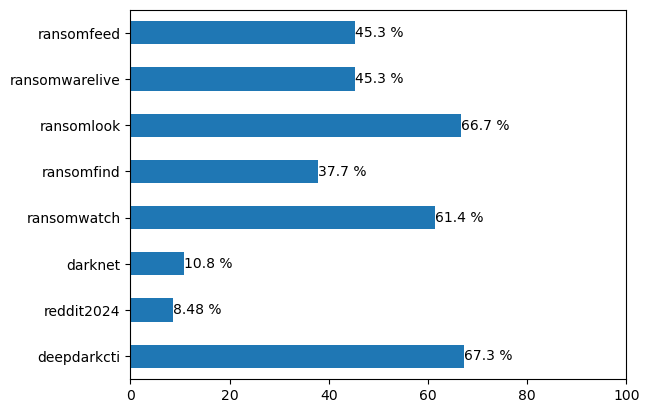

In [299]:
def get_tracked_status(only_active, indexer_dict: dict):
    tracking_status = { 'Group': [] }
    for i in indexer_dict.keys():
        tracking_status[i] = []
    
    concatted = all_groups
    if only_active:
        concatted = concatted[concatted['Available']]
    total = concatted['Group'].unique()

    for i in indexer_dict.keys():
        indexer = indexer_dict[i]
        if only_active:
            indexer = indexer[indexer['Available']]
        for group in total:
            tracking_status[i].append((indexer['Group'] == group).any())

    for group in total:
        tracking_status['Group'].append(group)
    
    return pd.DataFrame(tracking_status)

indexers = {
    'deepdarkcti': deepdarkcti,
    'reddit2024': reddit2024,
    'darknet': darknet,
    'ransomwatch': ransomwatch,
    'ransomfind': ransomfind,
    'ransomlook': ransomlook,
    'ransomwarelive': ransomwarelive,
    'ransomfeed': ransomfeed
}

tracking_status_all = get_tracked_status(False, indexers)

groups_all = tracking_status_all['Group'].count()
relative_all = tracking_status_all.sum(numeric_only=True).transform(lambda x: x * 100 / groups_all)

ax_all = relative_all.plot.barh(xlim=[0, 100])
ax_all.bar_label(ax_all.containers[0], fmt="%.3g %%")

print(groups_all)


In [7]:
import json
import pandas as pd

keywords = [
    "medical",
    "hospital",
    "clinic",
    "insur",
    "dent",
    "patient",
    "recover",
    "doctor",
    "nurs",
    "health",
    "facilit",
    "care",
    "lab",
    "pediat",
    "rehab",
    "krank",
    "mediz",
    "gesund",
]

with open("data/posts.json", "r") as f:
    posts = json.load(f)

df = pd.json_normalize(posts)

filtered = df['post_title'].apply(lambda d: any(keyword in d.lower() for keyword in keywords))

df = df[filtered]

df['discovered'] = pd.to_datetime(df['discovered'])
df['discovered'] = df['discovered'].dt.to_period('M')

df

,post_title,group_name,discovered
40,Wolfe Eye Clinic,lorenz,2021-04
55,OSF Healthcare System,xinglocker,2021-05
56,Coastal Family Health Center,xinglocker,2021-05
189,HealthCare Global Enterprises Ltd,avaddon,2021-09
201,BRIDGEWAY SENIOR HEALTHCARE,avaddon,2021-09
...,...,...,...
13716,freedomhomecare.net,threeam,2024-10
13726,Aspen Healthcare Data Leak,everest,2024-11
13730,MCNA Dental Data Leak,everest,2024-11
13746,Hope Valley Recovery,rhysida,2024-11


In [23]:
from pandas import DataFrame, to_datetime

results_all = { 'Title': [], 'Group': [], 'Date': [] }
results_medical = { 'Title': [], 'Group': [], 'Date': [] }
for post in posts:
    title = post['post_title'].lower()
    results_all['Title'].append(post['post_title'])
    results_all['Group'].append(post['group_name'])
    results_all['Date'].append(post['discovered'])
    for keyword in keywords:
        if keyword in title:
            results_medical['Title'].append(post['post_title'])
            results_medical['Group'].append(post['group_name'])
            results_medical['Date'].append(post['discovered'])
            break

df_all = DataFrame(results_all)

df_all['Date'] = to_datetime(df_all['Date'])
df_all['Month'] = df_all['Date'].dt.to_period('M')
print(len(results_all['Title']))

data_all = df_all['Month'].value_counts()

df_medical = DataFrame(results_medical)

df_medical['Date'] = to_datetime(df_medical['Date'])
df_medical['Month'] = df_medical['Date'].dt.to_period('M')
print(len(results_medical['Title']))


data_medical = df_medical['Month'].value_counts()

all = DataFrame({
    'all': data_all,
    'medical': data_medical,
})
all['part'] = all['medical'] / all['all']
all

13800
620


,all,medical,part
2020-01,1,NaN,NaN
2020-06,10,NaN,NaN
2020-07,1,NaN,NaN
2020-09,1,NaN,NaN
2020-10,3,NaN,NaN
2020-11,5,NaN,NaN
2020-12,12,NaN,NaN
2021-01,3,NaN,NaN
2021-02,2,NaN,NaN
2021-04,8,1.0,0.125000
